In [1]:
!export TF_ENABLE_ONEDNN_OPTS=0

In [2]:
import ccxt
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time
import pandas as pd

from datetime import datetime, timedelta
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

2024-01-11 10:20:37.994336: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 10:20:38.057377: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 10:20:38.610705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 10:20:38.614107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 10:20:39.602816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
# Create an instance of the exchange
exchange = ccxt.binance()

# Fetch OHLCV (Open, High, Low, Close, Volume) data for BTC/EUR pair
ohlcv = exchange.fetch_ohlcv('BTC/EUR', timeframe='1d')

In [4]:
df_ohlcv = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])

In [5]:
df_ohlcv['date'] = df_ohlcv['date'].apply(lambda x: datetime.fromtimestamp(x/1000))

In [6]:
df_ohlcv.head()

,date,open,high,low,close,volume
0,2022-08-30 02:00:00,20293.72,20597.38,19529.83,19780.00,2688.27834
1,2022-08-31 02:00:00,19784.33,20450.00,19770.00,19989.56,2444.01828
2,2022-09-01 02:00:00,19987.89,20289.77,19697.00,20217.60,1996.51253
3,2022-09-02 02:00:00,20215.00,20428.41,19855.69,20072.48,2268.39539
4,2022-09-03 02:00:00,20064.95,20170.00,19771.71,19938.86,864.40522


In [7]:
df_ohlcv.describe()

,date,open,high,low,close,volume
count,500,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2023-05-06 13:33:28.800000,24915.084140,25351.547760,24514.852360,24958.296320,1607.462172
min,2022-08-30 02:00:00,15387.420000,15487.350000,15120.000000,15379.210000,88.261530
25%,2023-01-01 19:00:00,20261.507500,20577.672500,19800.387500,20262.250000,478.847445
50%,2023-05-06 14:00:00,24879.180000,25187.985000,24545.180000,24887.455000,981.268610
75%,2023-09-08 08:00:00,27062.100000,27395.042500,26744.475000,27071.780000,2307.970342
max,2024-01-11 01:00:00,42945.190000,43952.000000,41642.000000,42943.930000,11341.142750
std,NaN,6348.125486,6481.886147,6218.709217,6390.410858,1620.034624


In [8]:
# Filter the DataFrame to start at the specific date
df_ohlcv_year = df_ohlcv[df_ohlcv['date'] >= df_ohlcv['date'].max() - timedelta(days=365)]

In [9]:
df_ohlcv_year.describe()

,date,open,high,low,close,volume
count,366,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2023-07-12 13:35:34.426229248,27382.899180,27874.419153,26951.461257,27452.806448,1174.168335
min,2023-01-11 01:00:00,16253.310000,16721.000000,16100.000000,16672.660000,88.261530
25%,2023-04-12 08:00:00,24274.385000,24709.140000,23989.135000,24316.180000,393.602688
50%,2023-07-12 14:00:00,25997.350000,26506.140000,25558.310000,26015.475000,681.614705
75%,2023-10-11 20:00:00,28070.375000,28444.332500,27637.912500,28084.120000,1253.000530
max,2024-01-11 01:00:00,42945.190000,43952.000000,41642.000000,42943.930000,7990.789180
std,NaN,5540.776137,5648.724899,5399.711661,5562.601918,1309.951167


In [10]:
df_year = df_ohlcv_year['open'].values

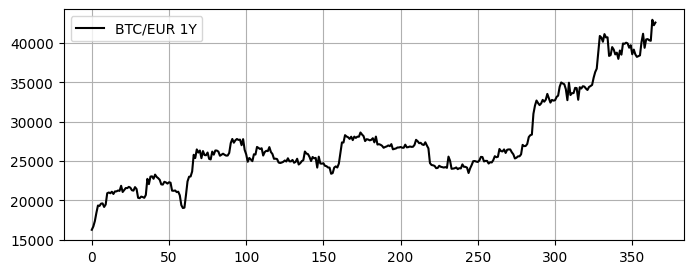

In [11]:
plt.figure(figsize=(8,3))
plt.plot(df_year, color='black', label='BTC/EUR 1Y')
plt.grid()
plt.legend();

In [12]:
df = df_ohlcv['open'].values
df = df.reshape(-1, 1)

In [13]:
# test train split
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

In [14]:
# scaling data
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

In [15]:
def create_custom_dataset(df):
    x = []
    y = []
    for i in range(50,df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [16]:
x_train, y_train = create_custom_dataset(dataset_train)
x_test, y_test = create_custom_dataset(dataset_test)

In [17]:
y_train.shape, y_test.shape

((350,), (100,))

In [18]:
x_train.shape, x_test.shape

((350, 50), (100, 50))

In [19]:
x_train[0]

array([0.37084992, 0.33234693, 0.34773331, 0.36489976, 0.35355801,
       0.34382322, 0.36113555, 0.342022  , 0.27345448, 0.29723021,
       0.2967714 , 0.4418294 , 0.46352499, 0.47359009, 0.50845737,
       0.36648254, 0.36917644, 0.33001962, 0.33342026, 0.35683695,
       0.3026286 , 0.31028777, 0.2688815 , 0.25707489, 0.32656305,
       0.33944828, 0.31157728, 0.3044336 , 0.34746347, 0.34022758,
       0.34860331, 0.34343547, 0.33548982, 0.32741038, 0.30902775,
       0.34577713, 0.37712889, 0.37419765, 0.37790063, 0.35284296,
       0.34463351, 0.34680435, 0.32619948, 0.32269378, 0.32854871,
       0.33656012, 0.3290506 , 0.32133322, 0.33152833, 0.33876573])

In [20]:
x_train[1]

array([0.33234693, 0.34773331, 0.36489976, 0.35355801, 0.34382322,
       0.36113555, 0.342022  , 0.27345448, 0.29723021, 0.2967714 ,
       0.4418294 , 0.46352499, 0.47359009, 0.50845737, 0.36648254,
       0.36917644, 0.33001962, 0.33342026, 0.35683695, 0.3026286 ,
       0.31028777, 0.2688815 , 0.25707489, 0.32656305, 0.33944828,
       0.31157728, 0.3044336 , 0.34746347, 0.34022758, 0.34860331,
       0.34343547, 0.33548982, 0.32741038, 0.30902775, 0.34577713,
       0.37712889, 0.37419765, 0.37790063, 0.35284296, 0.34463351,
       0.34680435, 0.32619948, 0.32269378, 0.32854871, 0.33656012,
       0.3290506 , 0.32133322, 0.33152833, 0.33876573, 0.31895754])

In [21]:
x_train[1][-1] == y_train[0]

True

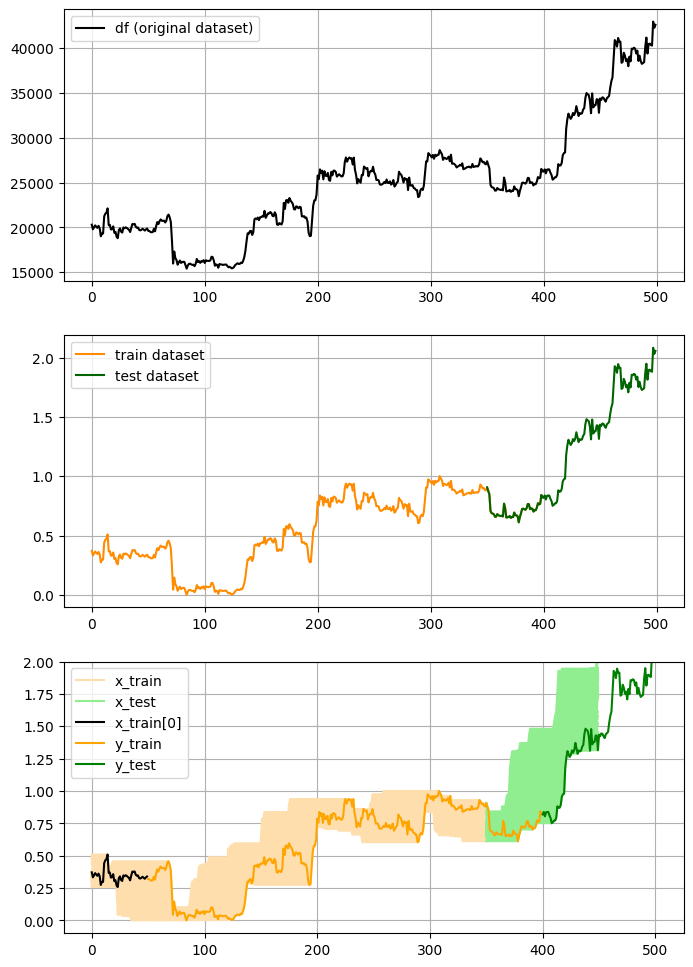

In [22]:
fig, ax = plt.subplots(figsize=(8, 12), nrows=3)
ax[0].plot(df, color='black', label='df (original dataset)')
ax[0].grid()
ax[0].legend();

ax[1].plot(dataset_train, color='darkorange', label='train dataset')
ax[1].plot(range(350, 500), dataset_test, color='darkgreen', label='test dataset')
ax[1].grid()
ax[1].legend();

ax[2].plot(x_train, color='navajowhite')
        
ax[2].plot(x_train[0], color='navajowhite', label='x_train')  # label
ax[2].plot(range(y_train.shape[0], y_train.shape[0]+50), x_test[0], color='lightgreen', label='x_test')  # label
ax[2].plot(x_train[0], color='black', label='x_train[0]')
ax[2].plot(range(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), x_test, color='lightgreen')
ax[2].plot(range(50, y_train.shape[0]+50), y_train, color='orange', label='y_train')
ax[2].plot(range(y_train.shape[0]+50, y_train.shape[0]+y_test.shape[0]+50), y_test, color='green', label='y_test')
ax[2].set_xlim(-25, y_train.shape[0]+y_test.shape[0]+50+25)
ax[2].set_ylim(-0.1, 2)
ax[2].grid();
ax[2].legend();

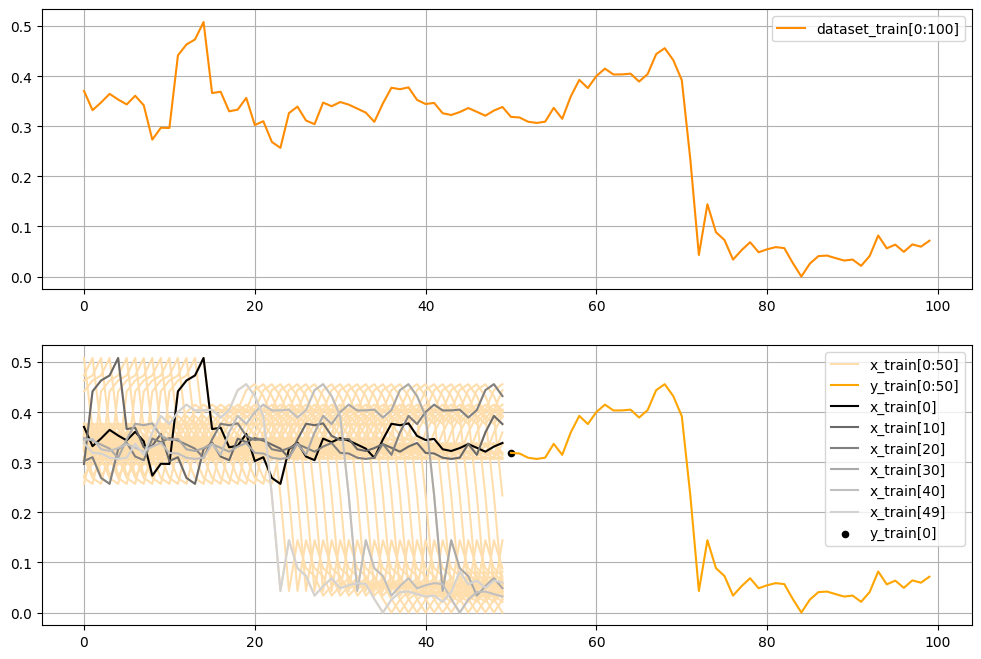

In [23]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2)

ax[0].plot(dataset_train[0], color='darkorange', label='dataset_train[0:100]')  # label
ax[0].plot(dataset_train[0:100], color='darkorange')
ax[0].grid();
ax[0].legend();

ax[1].plot(x_train[0], color='navajowhite', label='x_train[0:50]')  # label
ax[1].plot(x_train[0:50], color='navajowhite')
ax[1].plot(range(50, 100), y_train[0:50], color='orange', label='y_train[0:50]')
ax[1].plot(x_train[0], color='black', label='x_train[0]')
ax[1].plot(x_train[10], color='dimgrey', label='x_train[10]')
ax[1].plot(x_train[20], color='grey', label='x_train[20]')
ax[1].plot(x_train[30], color='darkgrey', label='x_train[30]')
ax[1].plot(x_train[40], color='silver', label='x_train[40]')
ax[1].plot(x_train[49], color='lightgrey', label='x_train[49]')
ax[1].scatter(50, y_train[0], label='y_train[0]', color='black', s=20)
ax[1].grid();
ax[1].legend();

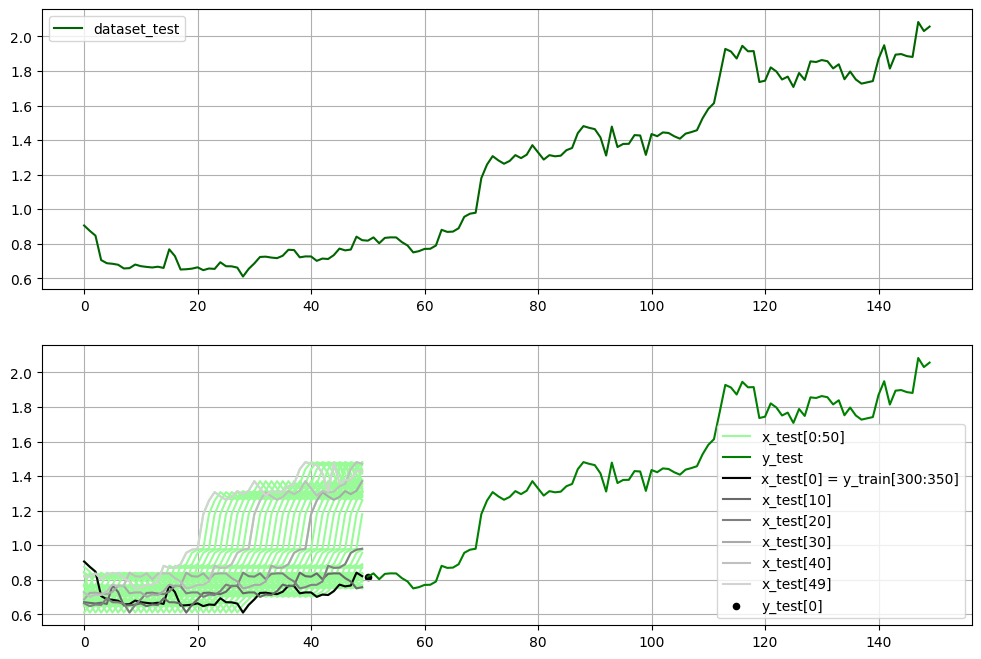

In [24]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2)

ax[0].plot(dataset_test[0], color='darkgreen', label='dataset_test')  # label
ax[0].plot(dataset_test, color='darkgreen')
ax[0].grid();
ax[0].legend();

ax[1].plot(x_test[0], color='palegreen', label='x_test[0:50]')  # label
ax[1].plot(x_test[0:50], color='palegreen')
ax[1].plot(range(50, 150), y_test, color='green', label='y_test')
ax[1].plot(x_test[0], color='black', label='x_test[0] = y_train[300:350]')
ax[1].plot(x_test[10], color='dimgrey', label='x_test[10]')
ax[1].plot(x_test[20], color='grey', label='x_test[20]')
ax[1].plot(x_test[30], color='darkgrey', label='x_test[30]')
ax[1].plot(x_test[40], color='silver', label='x_test[40]')
ax[1].plot(x_test[49], color='lightgrey', label='x_test[49]')
ax[1].scatter(50, y_test[0], label='y_test[0]', color='black', s=20)
ax[1].grid();
ax[1].legend();

In [25]:
# reshaping for LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape)
print(x_test.shape)

(350, 50, 1)
(100, 50, 1)


In [26]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

2024-01-11 10:20:49.429315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 10:20:49.429776: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 96)                74112     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 9

In [28]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [29]:
if not os.path.exists('models/btc_eur_baseline.keras'):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save('models/btc_eur_baseline.keras')

In [30]:
model = load_model('models/btc_eur_baseline.keras')

In [31]:
def get_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    return dict(mae=mae, mape=mape, r2=r2)

In [32]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # inverse MinMaxScaler()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
print('TEST SET:', get_metrics(y_test_inv, predictions))

4/4 [==============================] - 1s 14ms/step
TEST SET: {'mae': 1557.5742992187502, 'mape': 4.247253493580526, 'r2': 0.8565827360461834}


In [33]:
predictions_train = model.predict(x_train)
predictions_train = scaler.inverse_transform(predictions_train)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
print('TRAIN SET:', get_metrics(y_train_inv, predictions_train))

11/11 [==============================] - 0s 24ms/step
TRAIN SET: {'mae': 486.6078662946428, 'mape': 2.2121259133715365, 'r2': 0.9667121425434528}


In [34]:
# Make forecast
future_steps = 30
forecast = []
input_data = x_test[-1]

for _ in range(future_steps):
    input_data = input_data.reshape((1, 50, 1))
    prediction = model.predict(input_data, verbose=0)
    forecast.append(prediction[0, 0])
    input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

forecast_inversed = scaler.inverse_transform(np.array(forecast).reshape((future_steps, 1)))

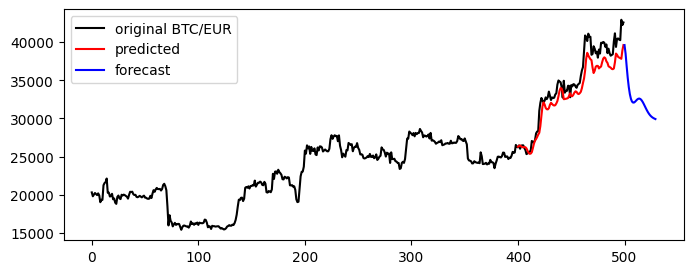

In [35]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(df, color='black', label='original')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)), predictions, color='red', label='predicted')
plt.plot(range(len(df), len(df)+future_steps), forecast_inversed, color = 'blue', label='forecast')
plt.legend();

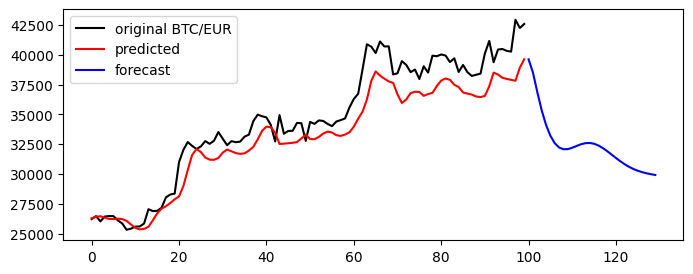

In [36]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(y_test_inv, color='black', label = 'original')
plt.plot(predictions, color = 'red', label='predicted')
plt.plot(range(100, 100+future_steps), forecast_inversed, color = 'blue', label='forecast')
plt.legend();

In [37]:
today = datetime.today()
next_day = today + timedelta(days=1)
one_week = today + timedelta(days=7)
one_month = today + timedelta(days=30)
today_value = df[-1][0]
next_day_forcasted_value = forecast_inversed[0][0]
one_week_forcasted_value = forecast_inversed[6][0]
one_month_forcasted_value = forecast_inversed[29][0]
change_value = np.abs(today_value - next_day_forcasted_value)
change_description = '-' if today_value > next_day_forcasted_value else '+'
message = f"""
BTC/EUR

TODAY      ({today.date()}): {today_value} EUR

FORECASTED ({next_day.date()}): {next_day_forcasted_value:.2f} EUR ({change_description}{change_value:.2f})
           ({one_week.date()}): {one_week_forcasted_value:.2f} EUR
           ({one_month.date()}): {one_month_forcasted_value:.2f} EUR
"""
print(message)


BTC/EUR

TODAY      (2024-01-07): 40334.36 EUR

FORECASTED (2024-01-08): 37981.53 EUR (-2352.83)
           (2024-01-14): 32306.16 EUR
           (2024-02-06): 29767.58 EUR



---

In [38]:
!export TF_ENABLE_ONEDNN_OPTS=0

In [39]:
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

class CustomKerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self, 
        units=96,
        activation='tanh',
        dropout_rate=0.2,
        recurrent_dropout=0.1,
        epochs=150, 
        batch_size=32, 
        validation_split=0.1,
        loss='mean_squared_error',
        learning_rate=0.0055,
        early_stopping=False,
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ):
        self.units = units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.recurrent_dropout = recurrent_dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.loss = loss
        self.learning_rate = learning_rate
        self.early_stopping = early_stopping
        self.monitor = monitor
        self.patience = monitor
        self.restore_best_weights = monitor
        self.model = self._build_model()

    def fit(self, X, y):
        if not self.early_stopping:
            self.monitor = None
            self.patience = None
            self.restore_best_weights = None
        
        state = self.__getstate__()
        self.__setstate__(state)
        optimizer = Adam(learning_rate=self.learning_rate)
        
        callbacks = None
        if self.early_stopping:
            early_stopping_params = {param: self.__dict__[param] for param in ['monitor', 'patience', 'restore_best_weights'] if self.__dict__[param]}
            early_stopping = EarlyStopping(**early_stopping_params)
            callbacks = [early_stopping]
            
        self.model.compile(loss=self.loss, optimizer=optimizer)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=self.validation_split, callbacks=callbacks)

    def predict(self, X):
        return self.model.predict(X)

    def _build_model(self):
        model = Sequential()
        model.add(LSTM(units=self.units, activation=self.activation, recurrent_dropout=self.recurrent_dropout, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(Dropout(self.dropout_rate))
        model.add(LSTM(units=self.units, activation=self.activation, recurrent_dropout=self.recurrent_dropout, return_sequences=True))
        model.add(Dropout(self.dropout_rate))
        model.add(LSTM(units=self.units, activation=self.activation, recurrent_dropout=self.recurrent_dropout))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(units=1))
        return model

    def __getstate__(self):
        state = self.__dict__.copy()
        del state['model']
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        self.model = self._build_model()

In [40]:
start_time = time.time()

In [41]:
time.strftime("%H:%M")

'13:23'

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from scipy.stats import uniform


keras_model = CustomKerasRegressor()

distributions = {
    'units': [96],  # [32, 64, 96, 128]
    'activation': [None, 'tanh', 'softsign'],  # [None, 'tanh', 'softsign']
    'dropout_rate': [0.1, 0.2, 0.3],  # [0.1, 0.2, 0.3]
    'recurrent_dropout': [0.0, 0.1, 0.2],  # [0.0, 0.1, 0.2]
    'epochs': [100, 150],  # [25, 50, 100, 150, 200, 300, 500],
    'batch_size': [32],  # [16, 32, 64, 128],
    'validation_split': [0.1],  # [0.1, 0.2, 0.3]
    'learning_rate': uniform(loc=0.004, scale=0.002),  # uniform(loc=0.00001, scale=0.00999),
    # 'monitor': ['loss', 'val_loss'],  # ['loss', 'val_loss']
    # 'patience': [5, 10, 15, 30],  # [5, 10, 15],
    # 'restore_best_weights': [True, False],  # [True, False]
    'early_stopping': [False]  # [True, False]
}
optimizer = RandomizedSearchCV(
    keras_model,
    distributions,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=10,
    n_jobs=-1,
    pre_dispatch=4,
)
optimizer.fit(x_train, y_train)

2024-01-07 13:23:10.009985: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:23:10.010367: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:23:10.011341: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:23:10.011994: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:23:10.017916: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical re

Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
7/7 [==============================] - 3s 138ms/step - loss: 0.1746 - val_loss: 0.0016
Epoch 2/150
7/7 [==============================] - 1s 102ms/step - loss: 0.0236 - val_loss: 0.0062
Epoch 3/150
7/7 [==============================] - 1s 96ms/step - loss: 0.0257 - val_loss: 0.0077
Epoch 4/150
7/7 [==============================] - 1s 109ms/step - loss: 0.0203 - val_loss: 0.0039
Epoch 5/150
7/7 [==============================] - 6s 220ms/step - loss: 0.6746 - val_loss: 0.1880
Epoch 2/150
7/7 [==============================] - 5s 203ms/step - loss: 0.1173 - val_loss: 0.0035
Epoch 2/150
7/7 [==============================] - 6s 212ms/step - loss: 0.3250 - val_loss: 0.2756
Epoch 2/150
7/7 [==============================] - 1s 78ms/step - loss: 0.0182 - val_loss: 0.0026
Epoch 6/150
7/7 [==============================] - 1s 99ms/step - loss: 0.0131 - val_loss: 0.0046
Epoch 7/150
7/7 [==============================] - 1s 130ms/step - loss: 0.1

2024-01-07 13:25:37.406951: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:25:37.406949: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:25:37.406949: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:25:37.406952: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly 

Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
7/7 [==============================] - 3s 126ms/step - loss: 0.1471 - val_loss: 0.0022
Epoch 2/150
7/7 [==============================] - 3s 133ms/step - loss: 0.0900 - val_loss: 0.0109
Epoch 2/150
7/7 [==============================] - 1s 83ms/step - loss: 0.0326 - val_loss: 0.0215
Epoch 3/150
7/7 [==============================] - 1s 81ms/step - loss: 0.0268 - val_loss: 0.0080
Epoch 3/150
7/7 [==============================] - 1s 85ms/step - loss: 0.0201 - val_loss: 0.0046
Epoch 4/150
7/7 [==============================] - 1s 88ms/step - loss: 0.0212 - val_loss: 0.0066
Epoch 4/150
7/7 [==============================] - 1s 99ms/step - loss: 0.0131 - val_loss: 0.0021
Epoch 5/150
7/7 [==============================] - 1s 96ms/step - loss: 0.0149 - val_loss: 0.0095
Epoch 5/150
7/7 [==============================] - 1s 98ms/step - loss: 0.0101 - val_loss: 0.0022
Epoch 6/150
7/7 [==============================] - 5s 236ms/step - loss: 21.1170

2024-01-07 13:27:28.457553: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:27:28.459828: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:27:28.500533: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:27:28.500977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 96ms/step - loss: 0.0050 - val_loss: 9.5862e-04
Epoch 124/150
7/7 [==============================] - 1s 98ms/step - loss: 0.0138 - val_loss: 0.0033
Epoch 124/150
7/7 [==============================] - 1s 104ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 125/150
7/7 [==============================] - ETA: 0s - loss: 0.0139

2024-01-07 13:27:29.490057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 107ms/step - loss: 0.0139 - val_loss: 0.0036
Epoch 125/150
7/7 [==============================] - 1s 104ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 126/150
7/7 [==============================] - 1s 97ms/step - loss: 0.0129 - val_loss: 0.0026
Epoch 126/150
7/7 [==============================] - 1s 96ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 127/150
4/7 [================>.............] - ETA: 0s - loss: 0.0122

2024-01-07 13:27:30.692276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:27:30.692731: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 98ms/step - loss: 0.0138 - val_loss: 0.0028
Epoch 127/150
7/7 [==============================] - 1s 100ms/step - loss: 0.0060 - val_loss: 9.6460e-04
Epoch 128/150
7/7 [==============================] - 1s 100ms/step - loss: 0.0133 - val_loss: 0.0039
Epoch 128/150
7/7 [==============================] - 1s 97ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 129/150
7/7 [==============================] - 1s 95ms/step - loss: 0.0127 - val_loss: 0.0019
Epoch 129/150
7/7 [==============================] - 1s 95ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 130/150
7/7 [==============================] - 1s 95ms/step - loss: 0.0130 - val_loss: 0.0026
Epoch 130/150
7/7 [==============================] - 1s 95ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 131/150
7/7 [==============================] - 1s 97ms/step - loss: 0.0133 - val_loss: 0.0037
Epoch 131/150
7/7 [==============================] - 1s 96ms/step - loss: 0.0044 - val_loss: 9.0082e-04
Epoc

2024-01-07 13:27:49.127881: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:27:49.129780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:27:49.164175: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:27:49.164721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


6/7 [========================>.....] - ETA: 0s - loss: 0.0212

2024-01-07 13:27:49.345026: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:27:49.346691: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:27:49.382009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:27:49.382460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 91ms/step - loss: 0.0214 - val_loss: 0.0043
Epoch 16/150
4/7 [================>.............] - ETA: 0s - loss: 0.0200

2024-01-07 13:27:49.827494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 90ms/step - loss: 0.0203 - val_loss: 0.0030
Epoch 17/150


2024-01-07 13:27:50.044314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 93ms/step - loss: 0.0215 - val_loss: 0.0025
Epoch 18/150
1/7 [===>..........................] - ETA: 0s - loss: 0.0259

2024-01-07 13:27:50.718633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:27:50.718948: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/7 [================>.............] - ETA: 0s - loss: 0.0216

2024-01-07 13:27:50.925194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:27:50.926151: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 90ms/step - loss: 0.0192 - val_loss: 0.0028
Epoch 19/150
7/7 [==============================] - 1s 88ms/step - loss: 0.0194 - val_loss: 0.0033
Epoch 20/150
7/7 [==============================] - 1s 90ms/step - loss: 0.0198 - val_loss: 0.0026
Epoch 21/150
7/7 [==============================] - 1s 89ms/step - loss: 0.0180 - val_loss: 0.0063
Epoch 22/150
7/7 [==============================] - 1s 87ms/step - loss: 0.0187 - val_loss: 0.0024
Epoch 23/150
7/7 [==============================] - 1s 91ms/step - loss: 0.0194 - val_loss: 0.0026
Epoch 24/150
7/7 [==============================] - 1s 89ms/step - loss: 0.0187 - val_loss: 0.0036
Epoch 25/150
7/7 [==============================] - 1s 97ms/step - loss: 0.0191 - val_loss: 0.0023
Epoch 26/150
7/7 [==============================] - 1s 95ms/step - loss: 0.0194 - val_loss: 0.0023
Epoch 27/150
7/7 [==============================] - 1s 90ms/step - loss: 0.0197 - val_loss: 0.0031
Epoch 28/150
7/7 [=====

2024-01-07 13:28:04.248472: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:28:04.251739: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:28:04.294507: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:28:04.295038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 93ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 13/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0162 - val_loss: 0.0024
Epoch 39/150
7/7 [==============================] - 1s 96ms/step - loss: 0.0097 - val_loss: 0.0013
Epoch 14/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0170

2024-01-07 13:28:05.242604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 109ms/step - loss: 0.0160 - val_loss: 0.0020
Epoch 40/150
7/7 [==============================] - 1s 103ms/step - loss: 0.0112 - val_loss: 0.0016
Epoch 15/100
7/7 [==============================] - 1s 103ms/step - loss: 0.0093 - val_loss: 0.0013
Epoch 15/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0112 - val_loss: 0.0011
Epoch 16/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0152 - val_loss: 0.0025
Epoch 41/150
7/7 [==============================] - 1s 97ms/step - loss: 0.0081 - val_loss: 0.0012
Epoch 16/100
4/7 [================>.............] - ETA: 0s - loss: 0.0153

2024-01-07 13:28:06.556975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:28:06.557537: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 97ms/step - loss: 0.0096 - val_loss: 0.0015
Epoch 17/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0161 - val_loss: 0.0023
Epoch 42/150
7/7 [==============================] - 1s 99ms/step - loss: 0.0076 - val_loss: 0.0032
Epoch 17/100
7/7 [==============================] - 1s 98ms/step - loss: 0.0089 - val_loss: 0.0018
Epoch 18/100
7/7 [==============================] - 1s 106ms/step - loss: 0.0157 - val_loss: 0.0019
Epoch 43/150
7/7 [==============================] - 1s 96ms/step - loss: 0.0079 - val_loss: 0.0027
Epoch 18/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0114 - val_loss: 0.0012
Epoch 19/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0165 - val_loss: 0.0025
Epoch 44/150
7/7 [==============================] - 1s 97ms/step - loss: 0.0073 - val_loss: 0.0030
Epoch 19/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0114 - val_loss: 0.0020
Epoch 20/100
7/7 [==

2024-01-07 13:32:39.810119: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:32:39.812439: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:32:39.854273: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:32:39.854744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 90ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 82/150
7/7 [==============================] - 1s 92ms/step - loss: 0.0044 - val_loss: 0.0010
Epoch 60/150
7/7 [==============================] - 1s 92ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 83/150
1/7 [===>..........................] - ETA: 0s - loss: 0.0040

2024-01-07 13:32:40.610051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 92ms/step - loss: 0.0048 - val_loss: 9.6638e-04
Epoch 61/150
7/7 [==============================] - 1s 92ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 84/150
7/7 [==============================] - 1s 90ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 62/150
2/7 [=======>......................] - ETA: 0s - loss: 0.0044

2024-01-07 13:32:41.605430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:32:41.605702: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 91ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 85/150
7/7 [==============================] - 5s 235ms/step - loss: 0.7837 - val_loss: 0.2328
Epoch 2/150
7/7 [==============================] - 1s 90ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 63/150
7/7 [==============================] - 1s 92ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 86/150
7/7 [==============================] - 1s 95ms/step - loss: 0.0621 - val_loss: 0.0709
Epoch 3/150
7/7 [==============================] - 1s 91ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 64/150
7/7 [==============================] - 1s 91ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 87/150
7/7 [==============================] - 1s 91ms/step - loss: 0.0385 - val_loss: 0.0027
Epoch 4/150
7/7 [==============================] - 1s 91ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 65/150
7/7 [==============================] - 1s 93ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 88/150
7/7 [=======

2024-01-07 13:33:43.151540: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:33:43.153440: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:33:43.190366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:33:43.191701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 95ms/step - loss: 0.0244 - val_loss: 0.0020
Epoch 73/150
7/7 [==============================] - 1s 89ms/step - loss: 0.0053 - val_loss: 9.7342e-04
Epoch 93/150
5/7 [====================>.........] - ETA: 0s - loss: 0.0182

2024-01-07 13:33:43.990629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 93ms/step - loss: 0.0193 - val_loss: 0.0023
Epoch 74/150
7/7 [==============================] - 1s 88ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 94/150
7/7 [==============================] - 1s 90ms/step - loss: 0.0047 - val_loss: 8.8120e-04
Epoch 95/150
7/7 [==============================] - 1s 93ms/step - loss: 0.0194 - val_loss: 0.0019
Epoch 75/150
1/7 [===>..........................] - ETA: 0s - loss: 0.0252

2024-01-07 13:33:44.987716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:33:44.988160: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 91ms/step - loss: 0.0041 - val_loss: 9.9262e-04
Epoch 96/150
7/7 [==============================] - 1s 95ms/step - loss: 0.0225 - val_loss: 0.0021
Epoch 76/150
7/7 [==============================] - 1s 88ms/step - loss: 0.0045 - val_loss: 9.9002e-04
Epoch 97/150
7/7 [==============================] - 1s 93ms/step - loss: 0.0222 - val_loss: 0.0019
Epoch 77/150
7/7 [==============================] - 1s 89ms/step - loss: 0.0042 - val_loss: 8.9163e-04
Epoch 98/150
7/7 [==============================] - 1s 92ms/step - loss: 0.0197 - val_loss: 0.0021
Epoch 78/150
7/7 [==============================] - 1s 90ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 99/150
7/7 [==============================] - 1s 120ms/step - loss: 0.0194 - val_loss: 0.0022
Epoch 79/150
7/7 [==============================] - 1s 85ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 100/150
7/7 [==============================] - 1s 95ms/step - loss: 0.0221 - val_loss: 0.0020
Epoch 80/

2024-01-07 13:34:04.549143: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 13:34:04.552654: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:34:04.594837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 13:34:04.595646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 112ms/step - loss: 0.0207 - val_loss: 0.0020
Epoch 103/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0082 - val_loss: 0.0036
Epoch 20/150
7/7 [==============================] - 1s 110ms/step - loss: 0.0203 - val_loss: 0.0018
Epoch 104/150
7/7 [==============================] - 1s 97ms/step - loss: 0.0036 - val_loss: 7.2848e-04
Epoch 127/150


2024-01-07 13:34:05.541775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 110ms/step - loss: 0.0068 - val_loss: 0.0012
Epoch 21/150
7/7 [==============================] - 1s 97ms/step - loss: 0.0039 - val_loss: 7.0889e-04
Epoch 128/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0141 - val_loss: 0.0018
Epoch 105/150
7/7 [==============================] - 1s 97ms/step - loss: 0.0040 - val_loss: 7.3630e-04
Epoch 129/150


2024-01-07 13:34:06.843722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:34:06.844025: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 108ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 22/150
7/7 [==============================] - 1s 109ms/step - loss: 0.0170 - val_loss: 0.0017
Epoch 106/150
7/7 [==============================] - 1s 98ms/step - loss: 0.0041 - val_loss: 6.9738e-04
Epoch 130/150
7/7 [==============================] - 1s 106ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 23/150
7/7 [==============================] - 1s 111ms/step - loss: 0.0191 - val_loss: 0.0018
Epoch 107/150
7/7 [==============================] - 1s 102ms/step - loss: 0.0036 - val_loss: 7.0355e-04
Epoch 131/150
7/7 [==============================] - 1s 111ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 24/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0180 - val_loss: 0.0017
Epoch 108/150
7/7 [==============================] - 1s 110ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 25/150
7/7 [==============================] - 1s 107ms/step - loss: 0.0185 - val_loss: 0.0017
E

RandomizedSearchCV(cv=3,
                   estimator=CustomKerasRegressor(patience='val_loss',
                                                  restore_best_weights='val_loss'),
                   n_jobs=-1,
                   param_distributions={'activation': [None, 'tanh',
                                                       'softsign'],
                                        'batch_size': [32],
                                        'dropout_rate': [0.1, 0.2, 0.3],
                                        'early_stopping': [False],
                                        'epochs': [100, 150],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb29843f310>,
                                        'recurrent_dropout': [0.0, 0.1, 0.2],
                                        'units': [96],
                                        'validation_split': [0.1]},
                   pre_dispatch=4, scoring='neg_mean_squared_error')

In [43]:
time.strftime("%H:%M")

'13:40'

In [44]:
f"Elapsed time: {round((time.time() - start_time)/60, 1)} minutes"

'Elapsed time: 17.8 minutes'

In [45]:
optimizer.cv_results_

{'mean_fit_time': array([142.16117915, 132.12562052, 125.75663519,  82.36818393,
        130.6339701 ,  87.86961587, 121.76628844, 140.51548394,
         82.39663553, 131.25071009]),
 'std_fit_time': array([ 0.34961185, 16.89307993,  4.68482664,  6.51389833, 25.12947299,
         5.00078771, 18.13546945, 10.05507217,  5.78909352, 11.2582601 ]),
 'mean_score_time': array([0.59448989, 0.49685351, 0.71049484, 1.51422294, 0.72258194,
        0.64155666, 1.51297251, 0.85381118, 0.71608996, 0.43938828]),
 'std_score_time': array([0.09422158, 0.13137518, 0.07857201, 0.25122782, 0.13608591,
        0.10782986, 0.13599786, 0.14250602, 0.03181463, 0.06473094]),
 'param_activation': masked_array(data=['tanh', 'softsign', None, 'tanh', 'softsign',
                    'softsign', 'tanh', None, None, 'tanh'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_batch_size': masked_ar

In [46]:
best_model = optimizer.best_estimator_
best_model

CustomKerasRegressor(learning_rate=0.004340817550199254, monitor=None,
                     patience=None, restore_best_weights=None)

In [47]:
# Make predictions
predictions = best_model.predict(x_test)
predictions = predictions.reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
test_metrics = get_metrics(y_test_inv, predictions)

4/4 [==============================] - 0s 18ms/step


In [48]:
predictions_train = best_model.predict(x_train)
predictions_train = predictions_train.reshape(-1, 1)
predictions_train = scaler.inverse_transform(predictions_train)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
train_metrics = get_metrics(y_train_inv, predictions_train)

11/11 [==============================] - 0s 18ms/step


In [49]:
model_filename = f"btc_eur_mape_{str(round(test_metrics['mape'], 2))}_r2_{str(round(test_metrics['r2'], 2))}.keras"
best_model.model.save(f'models/{model_filename}')

In [50]:
print('TEST SET:', test_metrics)
print('TRAIN SET:', train_metrics)
with open('models/summary.txt', 'a') as f:
    f.write(f'{test_metrics}\n')
    f.write(f'{train_metrics}\n')
    best_optimizer_params = best_model.get_params() 
    for k, v in best_optimizer_params.items():
        if k in ['units', 'activation', 'dropout_rate', 'recurrent_dropout', 'epochs', 'batch_size', 'validation_split', 
                 'loss', 'learning_rate', 'early_stopping', 'monitor', 'patience', 'restore_best_weights']:
            param_info = f'{k}: {v}'
            f.write(f'{param_info}\n')
            print(param_info)
    f.write('\n')

TEST SET: {'mae': 3459.3131875000004, 'mape': 9.432951839187037, 'r2': 0.3229463501246842}
TRAIN SET: {'mae': 492.2832936383929, 'mape': 2.194882038537395, 'r2': 0.9741869426185746}
activation: tanh
batch_size: 32
dropout_rate: 0.2
early_stopping: False
epochs: 150
learning_rate: 0.004340817550199254
loss: mean_squared_error
monitor: None
patience: None
recurrent_dropout: 0.1
restore_best_weights: None
units: 96
validation_split: 0.1


In [37]:
best_model_saved = load_model('models/btc_eur_best_model.keras')

In [38]:
f'units: {best_model_saved.layers[0].units}', \
f'dropout_rate: {best_model_saved.layers[1].rate}', \
f'learning_rate: {best_model_saved.optimizer.learning_rate.numpy()}'

('units: 128', 'dropout_rate: 0.2', 'learning_rate: 0.005030273459851742')

In [39]:
# Make predictions
predictions = best_model_saved.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
test_metrics_saved = get_metrics(y_test_inv, predictions)

4/4 [==============================] - 1s 17ms/step


In [40]:
predictions_train = best_model_saved.predict(x_train)
predictions_train = scaler.inverse_transform(predictions_train)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
train_metrics_saved = get_metrics(y_train_inv, predictions_train)

11/11 [==============================] - 0s 20ms/step


In [41]:
print('TEST SET:', test_metrics_saved)
print('TRAIN SET:', train_metrics_saved)

TEST SET: {'mae': 1359.2925609375002, 'mape': 3.7000264560930716, 'r2': 0.8823278740215619}
TRAIN SET: {'mae': 560.3743111607143, 'mape': 2.500893463337918, 'r2': 0.9621196922994365}


In [56]:
if test_metrics['mape'] < test_metrics_saved['mape'] and test_metrics['r2'] > test_metrics_saved['r2']:
    best_model.model.save('models/btc_eur_best_model.keras')
    print("New best model saved.")

In [42]:
best_model_saved = load_model('models/btc_eur_best_model.keras')

In [43]:
# Make forecast
future_steps = 30
forecast = []
input_data = x_test[-1]

for _ in range(future_steps):
    input_data = input_data.reshape((1, 50, 1))
    prediction = best_model_saved.predict(input_data)
    forecast.append(prediction[0])
    input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

forecast_inversed = scaler.inverse_transform(np.array(forecast).reshape((future_steps, 1)))

1/1 [==============================] - 0s 17ms/step


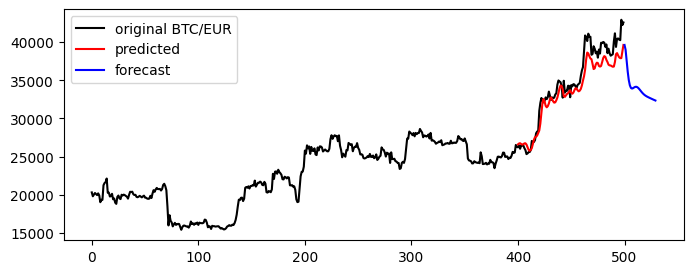

In [44]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(df, color='black', label='original BTC/EUR')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)), predictions, color='red', label='predicted')
plt.plot(range(len(df), len(df)+future_steps), forecast_inversed, color = 'blue', label='forecast')
plt.legend();

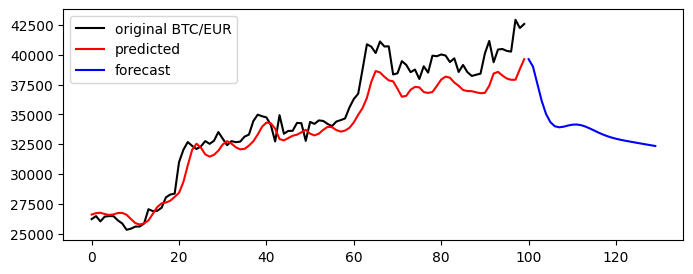

In [45]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(y_test_inv, color='black', label = 'original BTC/EUR')
plt.plot(predictions, color = 'red', label='predicted')
plt.plot(range(100, 100+future_steps), forecast_inversed, color = 'blue', label='forecast')
plt.legend();

In [46]:
today = datetime.today()
next_day = today + timedelta(days=1)
one_week = today + timedelta(days=7)
one_month = today + timedelta(days=30)
today_value = df[-1][0]
next_day_forcasted_value = forecast_inversed[0][0]
one_week_forcasted_value = forecast_inversed[6][0]
one_month_forcasted_value = forecast_inversed[29][0]
change_value = np.abs(today_value - next_day_forcasted_value)
change_description = '-' if today_value > next_day_forcasted_value else '+'
message = f"""
BTC/EUR

TODAY      ({today.date()}): {today_value} EUR

FORECASTED ({next_day.date()}): {next_day_forcasted_value:.2f} EUR ({change_description}{change_value:.2f})
           ({one_week.date()}): {one_week_forcasted_value:.2f} EUR
           ({one_month.date()}): {one_month_forcasted_value:.2f} EUR
"""
print(message)


BTC/EUR

TODAY      (2024-01-11): 42593.8 EUR

FORECASTED (2024-01-12): 39640.98 EUR (-2952.82)
           (2024-01-18): 34007.48 EUR
           (2024-02-10): 32350.23 EUR

